In [1]:
import numpy as np
import pandas as pd
import os
import nltk
from konlpy.tag import Okt
from konlpy.tag import Kkma
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from bs4 import BeautifulSoup
import requests
import re
import datetime
from tqdm import tqdm
import sys

In [2]:
# 페이지 url 형식에 맞게 바꾸어 주는 함수 만들기
  #입력된 수를 1, 11, 21, 31 ...만들어 주는 함수
def makePgNum(num):
    if num == 1:
        return num
    elif num == 0:
        return num+1
    else:
        return num+9*(num-1)

# 크롤링할 url 생성하는 함수 만들기(검색어, 크롤링 시작 페이지, 크롤링 종료 페이지)

def makeUrl(search, start_pg, end_pg):
    if start_pg == end_pg:
        start_page = makePgNum(start_pg)
        url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&start=" + str(start_page)
        print("생성url: ", url)
        return url
    else:
        urls = []
        for i in range(start_pg, end_pg + 1):
            page = makePgNum(i)
            url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search + "&start=" + str(page)
            urls.append(url)
        print("생성url: ", urls)
        return urls    

# html에서 원하는 속성 추출하는 함수 만들기 (기사, 추출하려는 속성값)
def news_attrs_crawler(articles,attrs):
    attrs_content=[]
    for i in articles:
        attrs_content.append(i.attrs[attrs])
    return attrs_content

# ConnectionError방지
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/98.0.4758.102"}

#html생성해서 기사크롤링하는 함수 만들기(url): 링크를 반환
def articles_crawler(url):
    #html 불러오기
    original_html = requests.get(i,headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")

    url_naver = html.select("div.group_news > ul.list_news > li div.news_area > div.news_info > div.info_group > a.info")
    url = news_attrs_crawler(url_naver,'href')
    return url

In [3]:
#####뉴스크롤링 시작#####

#검색어 입력
search = input("검색할 키워드를 입력해주세요:")
#검색 시작할 페이지 입력
page = int(input("\n크롤링할 시작 페이지를 입력해주세요. ex)1(숫자만입력):")) # ex)1 =1페이지,2=2페이지...
print("\n크롤링할 시작 페이지: ",page,"페이지")   
#검색 종료할 페이지 입력
page2 = int(input("\n크롤링할 종료 페이지를 입력해주세요. ex)1(숫자만입력):")) # ex)1 =1페이지,2=2페이지...
print("\n크롤링할 종료 페이지: ",page2,"페이지")   


# naver url 생성
url = makeUrl(search,page,page2)

#뉴스 크롤러 실행
news_titles = []
news_url =[]
news_contents =[]
news_dates = []
for i in url:
    url = articles_crawler(url)
    news_url.append(url)


#제목, 링크, 내용 1차원 리스트로 꺼내는 함수 생성
def makeList(newlist, content):
    for i in content:
        for j in i:
            newlist.append(j)
    return newlist

    
#제목, 링크, 내용 담을 리스트 생성
news_url_1 = []

#1차원 리스트로 만들기(내용 제외)
makeList(news_url_1,news_url)

#NAVER 뉴스만 남기기
final_urls = []
for i in tqdm(range(len(news_url_1))):
    if "news.naver.com" in news_url_1[i]:
        final_urls.append(news_url_1[i])
    else:
        pass

검색할 키워드를 입력해주세요: LGD

크롤링할 시작 페이지를 입력해주세요. ex)1(숫자만입력): 1



크롤링할 시작 페이지:  1 페이지



크롤링할 종료 페이지를 입력해주세요. ex)1(숫자만입력): 10



크롤링할 종료 페이지:  10 페이지
생성url:  ['https://search.naver.com/search.naver?where=news&sm=tab_pge&query=LGD&start=1', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=LGD&start=11', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=LGD&start=21', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=LGD&start=31', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=LGD&start=41', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=LGD&start=51', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=LGD&start=61', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=LGD&start=71', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=LGD&start=81', 'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=LGD&start=91']


100%|█████████████████████████████████████| 148/148 [00:00<00:00, 646621.87it/s]


In [4]:
# 뉴스 내용 크롤링

for i in tqdm(final_urls):
    #각 기사 html get하기
    news = requests.get(i,headers=headers)
    news_html = BeautifulSoup(news.text,"html.parser")
    # 뉴스 제목 가져오기
    title = news_html.select_one("#ct > div.media_end_head.go_trans > div.media_end_head_title > h2")
    if title == None:
        title = news_html.select_one("#content > div.end_ct > div > h2")
    
    # 뉴스 본문 가져오기
    content = news_html.select("article#dic_area")
    if content == []:
        content = news_html.select("#articeBody")
        
    # 기사 텍스트만 가져오기
    # list합치기
    content = ''.join(str(content))

    # html태그제거 및 텍스트 다듬기
    pattern1 = '<[^>]*>'
    title = re.sub(pattern=pattern1, repl='', string=str(title))
    content = re.sub(pattern=pattern1, repl='', string=content)
    pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
    content = content.replace(pattern2, '')

    news_titles.append(title)
    news_contents.append(content)

    try:
        html_date = news_html.select_one("div#ct> div.media_end_head.go_trans > div.media_end_head_info.nv_notrans > div.media_end_head_info_datestamp > div > span")
        news_date = html_date.attrs['data-date-time']
    except AttributeError:
        news_date = news_html.select_one("#content > div.end_ct > div > div.article_info > span > em")
        news_date = re.sub(pattern=pattern1,repl='',string=str(news_date))
    # 날짜 가져오기
    news_dates.append(news_date)

print("검색된 기사 갯수: 총 ",(page2+1-page)*10,'개')
# print("\n[뉴스 제목]")
# print(news_titles)
# print("\n[뉴스 링크]")
# print(final_urls)
# print("\n[뉴스 내용]")
# print(news_contents)

print('news_title: ',len(news_titles))
print('news_url: ',len(final_urls))
print('news_contents: ',len(news_contents))
print('news_dates: ',len(news_dates))

100%|███████████████████████████████████████████| 58/58 [00:08<00:00,  6.56it/s]

검색된 기사 갯수: 총  100 개
news_title:  58
news_url:  58
news_contents:  58
news_dates:  58


In [5]:
#데이터 프레임 만들기
news_df = pd.DataFrame({'date':news_dates,'title':news_titles,'link':final_urls,'content':news_contents})
news_df

#중복 행 지우기
news_df = news_df.drop_duplicates(keep='first',ignore_index=True)
print("중복 제거 후 행 개수: ",len(news_df))

#데이터 프레임 저장
# now = datetime.datetime.now() 
# news_df.to_csv('{}_{}.csv'.format(search,now.strftime('%Y%m%d_%H시%M분%S초')),encoding='utf-8-sig',index=False)

중복 제거 후 행 개수:  58


In [6]:
contents = news_df.content.tolist()
contents = ''.join(contents)

In [7]:
okt = Okt()

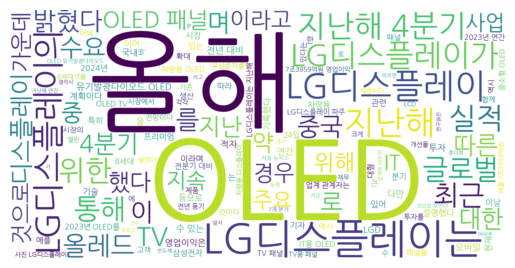

In [8]:
stops = ['합니다','하는','할','하고','한다','그리고','입니다','그','등','이런','및','제','더','하다','있다','기','용','되다','것','전','고']
wordcloud = WordCloud(font_path='./NanumGothic-Regular.ttf',background_color='white',stopwords=stops, max_words=150, width=2000, height=1000).generate(contents)
plt.figure()
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear') 
plt.show()           